In [4]:
library(magick)
library(fs)   # For listing files in directories
library(stringr)  # For filename parsing
library(pdftools)

In [5]:
library(ggplot2)
library(tidyr)
library(pheatmap)
library(dplyr)
library(gridExtra)

plot_link_count_heatmap <- function(hc_file, rbd_file, pd_file, output_folder) {
  # Read CSV files
  hc_data <- read.csv(hc_file)
  rbd_data <- read.csv(rbd_file)
  pd_data <- read.csv(pd_file)
  
  # Add disease status column
  hc_data$disease_status <- "HC"
  rbd_data$disease_status <- "RBD"
  pd_data$disease_status <- "PD"
  
  # Combine data
  combined_data <- bind_rows(hc_data, rbd_data, pd_data)
  
  # Reshape data into wide format
  link_count_matrix <- combined_data %>%
    select(gene, disease_status, link_count) %>%
    pivot_wider(names_from = disease_status, values_from = link_count, values_fill = list(link_count = 0))  # Fill missing values with 0
  
  link_count_matrix <- as.data.frame(link_count_matrix)

  # Use the 'gene' column as row names, then remove it once
  rownames(link_count_matrix) <- link_count_matrix$gene
  link_count_matrix$gene <- NULL

  # Now convert to matrix without stripping any additional columns
  link_count_matrix <- as.matrix(link_count_matrix)
  
  # Define custom color palette
  custom_colors <- c('#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#b30000','#7f0000')

  # Ensure output folder exists
  if (!dir.exists(output_folder)) {
    dir.create(output_folder, recursive = TRUE)
  }
  
  # Generate filename
  filename <- file.path(output_folder, "gene_link_count_heatmap.pdf")
  
  # Adjust PDF size dynamically based on the number of genes
  pdf_height <- max(10, nrow(link_count_matrix) * 0.3)  # Scale height based on gene count
  x <- pheatmap(link_count_matrix, 
           cluster_rows = TRUE, 
           cluster_cols = FALSE, 
           color = colorRampPalette(custom_colors)(100), 
           main = "Gene Link Count Heatmap",
           display_numbers = link_count_matrix,  # Show actual integer values
           number_format = "%.0f",  # Display numbers as integers
           labels_row = rownames(link_count_matrix),  # Ensure row names are displayed
           fontsize_row = 10)  # Increase row font size for readability

  # Save the heatmap to PDF
  pdf(filename, width=3, height=pdf_height)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
  message("Heatmap saved to: ", filename)
}

In [6]:
combine_gene_plots <- function(hc_folder, rbd_folder, pd_folder, output_folder) {
  
  # Create output folder if it doesn't exist
  if (!dir.exists(output_folder)) {
    dir.create(output_folder, recursive = TRUE)
  }
  
  # Create a temporary directory for storing PNGs
  temp_dir <- tempdir()

  # List available PDF files from each disease group
  hc_files <- dir_ls(hc_folder, glob = "*.pdf")
  rbd_files <- dir_ls(rbd_folder, glob = "*.pdf")
  pd_files  <- dir_ls(pd_folder, glob = "*.pdf")
  
  # Extract gene names from the file names
  gene_names <- unique(str_replace(basename(hc_files), ".pdf$", ""))
  gene_names <- unique(c(gene_names, str_replace(basename(rbd_files), ".pdf$", "")))
  gene_names <- unique(c(gene_names, str_replace(basename(pd_files), ".pdf$", "")))

  for (gene in gene_names) {
    
    # Define paths for each disease group
    hc_path <- file.path(hc_folder, paste0(gene, ".pdf"))
    rbd_path <- file.path(rbd_folder, paste0(gene, ".pdf"))
    pd_path  <- file.path(pd_folder, paste0(gene, ".pdf"))
    
    # Define temporary PNG paths
    hc_png <- file.path(temp_dir, paste0(gene, "_hc.png"))
    rbd_png <- file.path(temp_dir, paste0(gene, "_rbd.png"))
    pd_png  <- file.path(temp_dir, paste0(gene, "_pd.png"))

    # Convert PDFs to PNGs in the temporary directory
    if (file.exists(hc_path)) {
      pdf_convert(hc_path, dpi = 300, filenames = hc_png)
      hc_img <- image_read(hc_png)
    } else {
      hc_img <- image_blank(width = 800, height = 600, color = "white")
    }

    if (file.exists(rbd_path)) {
      pdf_convert(rbd_path, dpi = 300, filenames = rbd_png)
      rbd_img <- image_read(rbd_png)
    } else {
      rbd_img <- image_blank(width = 800, height = 600, color = "white")
    }

    if (file.exists(pd_path)) {
      pdf_convert(pd_path, dpi = 300, filenames = pd_png)
      pd_img <- image_read(pd_png)
    } else {
      pd_img <- image_blank(width = 800, height = 600, color = "white")
    }

    # Combine images vertically (stacked format)
    combined_plot <- image_append(c(hc_img, rbd_img, pd_img), stack = TRUE)

    # Save the combined plot in the output folder
    output_file <- file.path(output_folder, paste0(gene, "_combined.pdf"))
    image_write(combined_plot, output_file, format = "pdf")

    message("Saved combined plot for gene: ", gene)
  }
  
  message("All gene plots have been processed successfully!")
}

# Microglia Inflam DEGs

Heatmap saved to: ~/Documents/HCPDRBD/Signac_plots/Combined/DEGs_Cluster0_squeeze/gene_link_count_heatmap.pdf



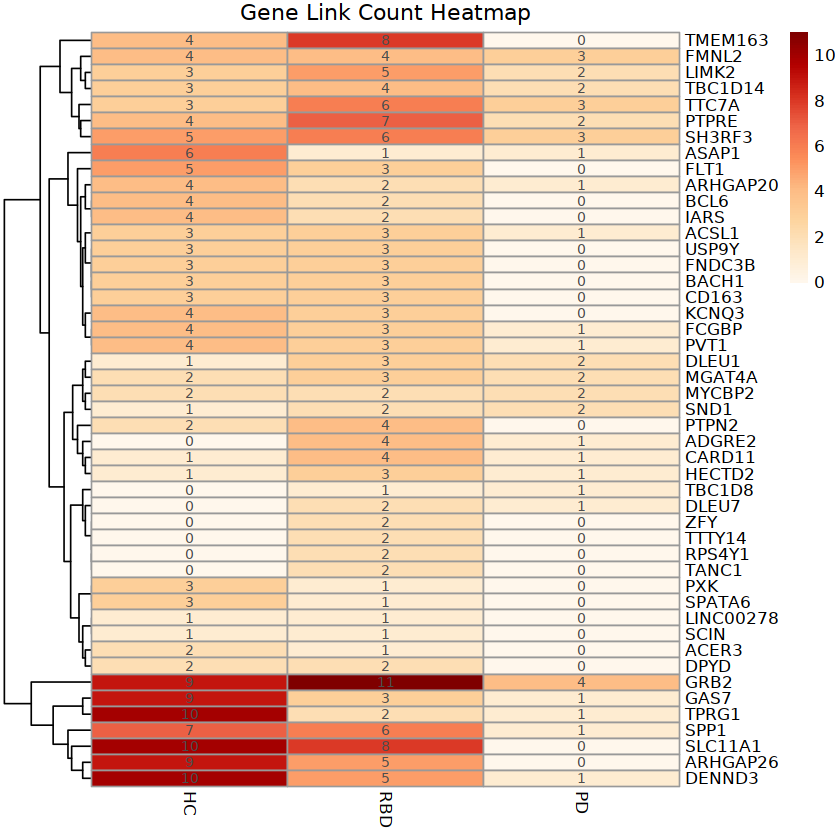

In [ ]:
# Define folder paths
hc_folder <- "../../Signac_plots/HC/DEGs_RBD_PD_vs_HC_Cluster0/gene_link_counts.csv"
rbd_folder <- "../../Signac_plots/RBD/DEGs_RBD_vs_HC_Cluster0/gene_link_counts.csv"
pd_folder <- "../../Signac_plots/PD/DEGs_PD_vs_HC_Cluster0/gene_link_counts.csv"
output_folder <- "../../Signac_plots/Combined/DEGs_Cluster0_squeeze"

# Combine plots
# combine_gene_plots(hc_folder, rbd_folder, pd_folder, output_folder)
plot_link_count_heatmap(hc_folder,rbd_folder, pd_folder, output_folder)

Heatmap saved to: ~/Documents/HCPDRBD/Signac_plots/Combined/DEGs_Cluster2_squeeze/gene_link_count_heatmap.pdf



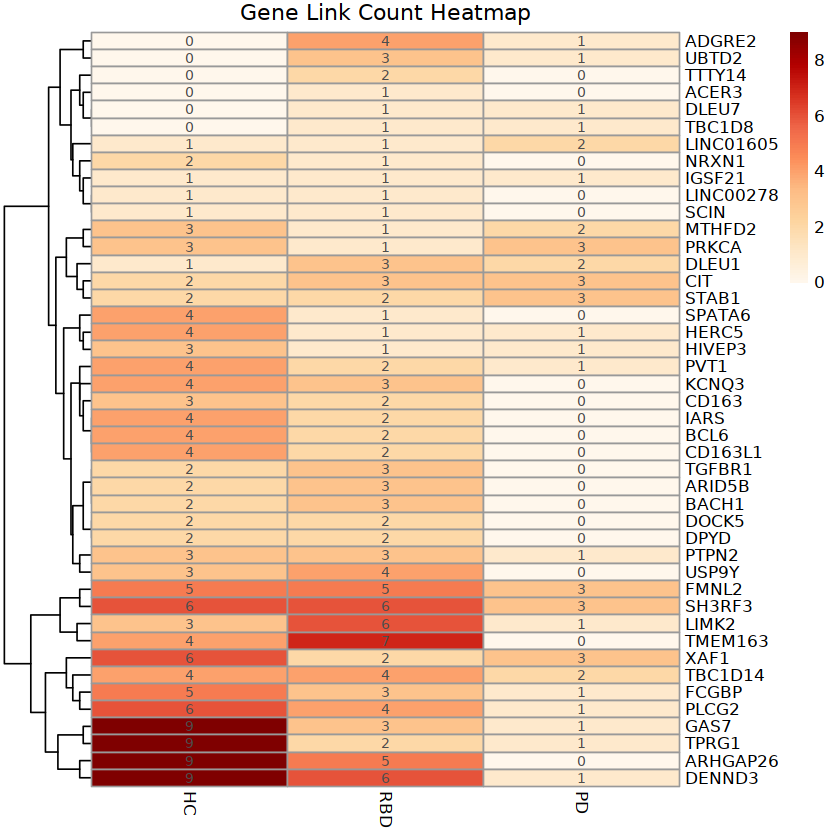

In [ ]:
# Define folder paths
hc_folder <- "../../Signac_plots/HC/DEGs_RBD_PD_vs_HC_Cluster2/gene_link_counts.csv"
rbd_folder <- "../../Signac_plots/RBD/DEGs_RBD_vs_HC_Cluster2/gene_link_counts.csv"
pd_folder <- "../../Signac_plots/PD/DEGs_PD_vs_HC_Cluster2/gene_link_counts.csv"
output_folder <- "../../Signac_plots/Combined/DEGs_Cluster2_squeeze"

# Combine plots
# combine_gene_plots(hc_folder, rbd_folder, pd_folder, output_folder)
plot_link_count_heatmap(hc_folder, rbd_folder, pd_folder, output_folder)

Heatmap saved to: ~/Documents/HCPDRBD/Signac_plots/Combined/DEGs_Cluster3_squeeze/gene_link_count_heatmap.pdf



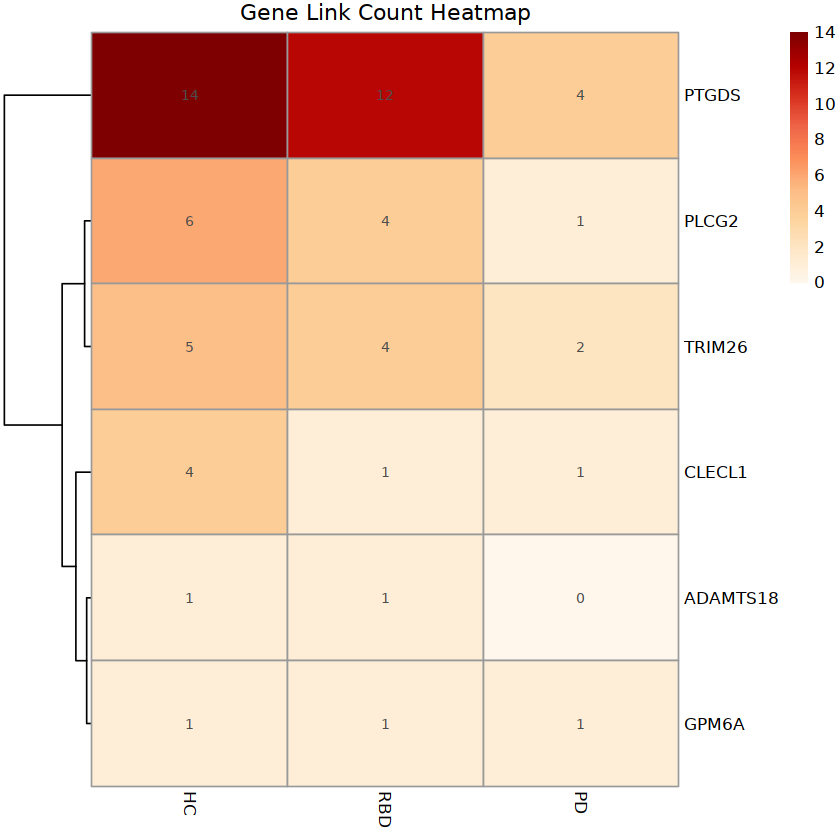

In [ ]:
# Define folder paths
hc_folder <- "../../Signac_plots/HC/DEGs_RBD_PD_vs_HC_Cluster3/gene_link_counts.csv"
rbd_folder <- "../../Signac_plots/RBD/DEGs_RBD_vs_HC_Cluster3/gene_link_counts.csv"
pd_folder <- "../../Signac_plots/PD/DEGs_PD_vs_HC_Cluster3/gene_link_counts.csv"
output_folder <- "../../Signac_plots/Combined/DEGs_Cluster3_squeeze"

# Combine plots
# combine_gene_plots(hc_folder, rbd_folder, pd_folder, output_folder)
plot_link_count_heatmap(hc_folder, rbd_folder, pd_folder, output_folder)

# Microglia Subtypes & DAM

Heatmap saved to: ~/Documents/HCPDRBD/Signac_plots/Combined/Marker_Genes_Cluster0_squeeze/gene_link_count_heatmap.pdf



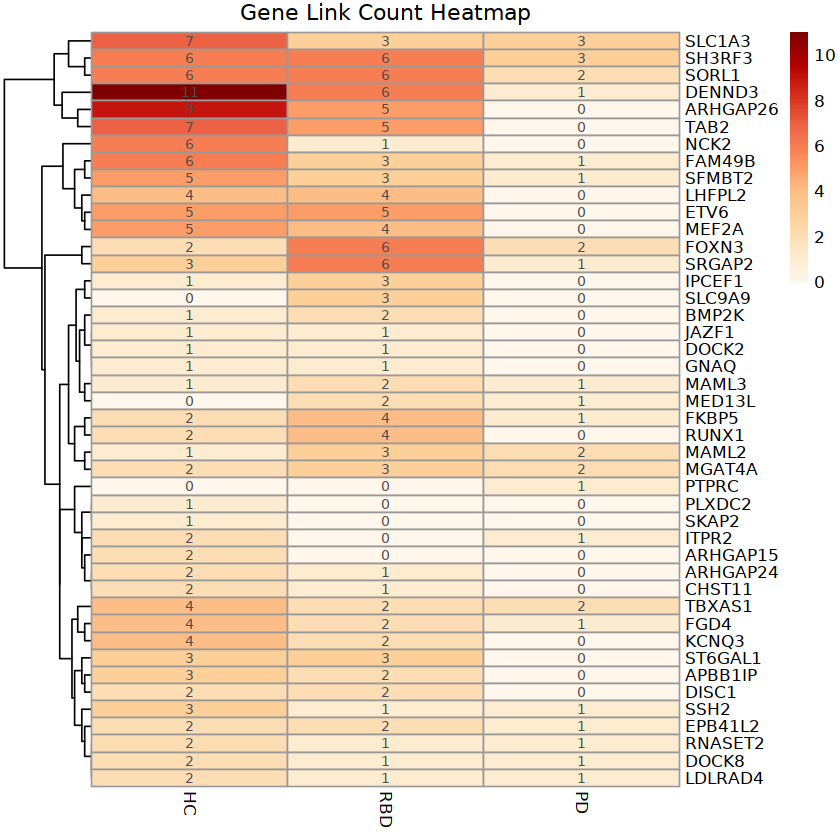

In [ ]:
# Define folder paths
hc_folder <- "../../Signac_plots/HC/Marker_Genes_Cluster0/gene_link_counts.csv"
rbd_folder <- "../../Signac_plots/RBD/Marker_Genes_Cluster0/gene_link_counts.csv"
pd_folder <- "../../Signac_plots/PD/Marker_Genes_Cluster0/gene_link_counts.csv"
output_folder <- "../../Signac_plots/Combined/Marker_Genes_Cluster0_squeeze"

# Combine plots
# combine_gene_plots(hc_folder, rbd_folder, pd_folder, output_folder)
plot_link_count_heatmap(hc_folder, rbd_folder, pd_folder, output_folder)

Heatmap saved to: ~/Documents/HCPDRBD/Signac_plots/Combined/Marker_Genes_Cluster0/gene_link_count_heatmap.pdf



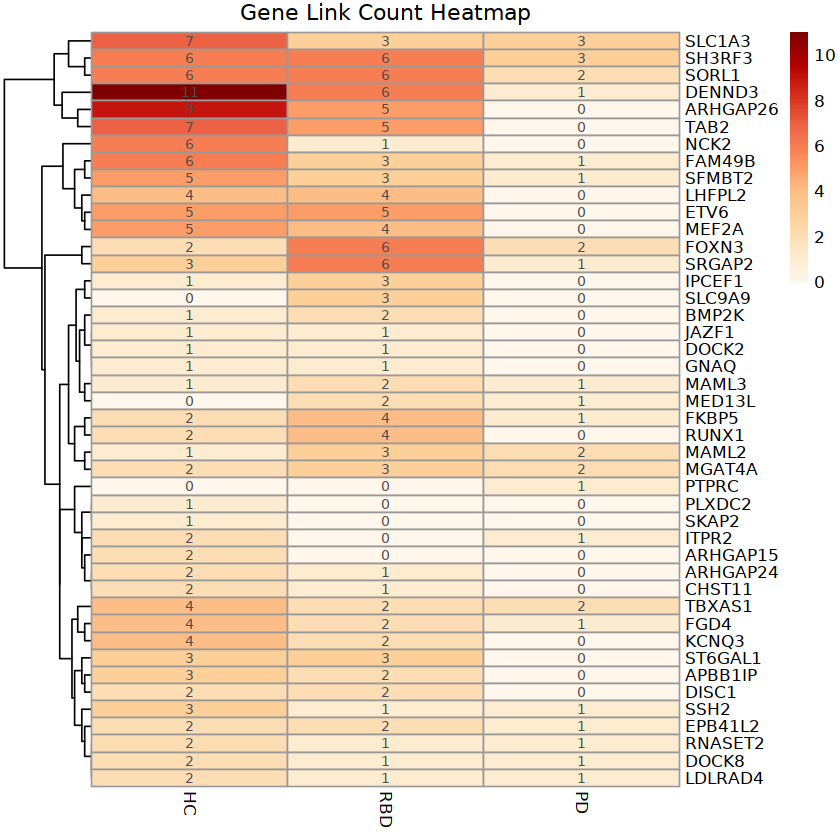

In [ ]:
# Define folder paths
hc_folder <- "../../Signac_plots/HC/Marker_Genes_Cluster0/gene_link_counts.csv"
rbd_folder <- "../../Signac_plots/RBD/Marker_Genes_Cluster0/gene_link_counts.csv"
pd_folder <- "../../Signac_plots/PD/Marker_Genes_Cluster0/gene_link_counts.csv"
output_folder <- "../../Signac_plots/Combined/Marker_Genes_Cluster0"

# Combine plots
# combine_gene_plots(hc_folder, rbd_folder, pd_folder, output_folder)
plot_link_count_heatmap(hc_folder, rbd_folder, pd_folder, output_folder)

Heatmap saved to: ~/Documents/HCPDRBD/Signac_plots/Combined/Marker_Genes_Cluster2_squeeze/gene_link_count_heatmap.pdf



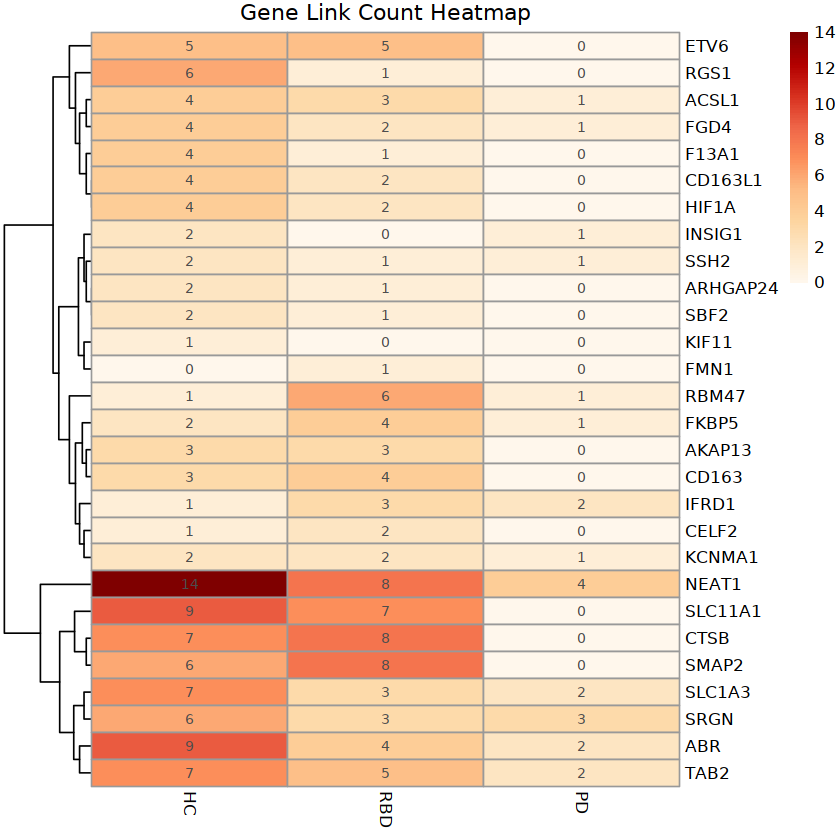

In [ ]:
# Define folder paths
hc_folder <- "../../Signac_plots/HC/Marker_Genes_Cluster2/gene_link_counts.csv"
rbd_folder <- "../../Signac_plots/RBD/Marker_Genes_Cluster2/gene_link_counts.csv"
pd_folder <- "../../Signac_plots/PD/Marker_Genes_Cluster2/gene_link_counts.csv"
output_folder <- "../../Signac_plots/Combined/Marker_Genes_Cluster2_squeeze"

# Combine plots
# combine_gene_plots(hc_folder, rbd_folder, pd_folder, output_folder)
plot_link_count_heatmap(hc_folder, rbd_folder, pd_folder, output_folder)

Heatmap saved to: ~/Documents/HCPDRBD/Signac_plots/Combined/Marker_Genes_Cluster3_squeeze/gene_link_count_heatmap.pdf



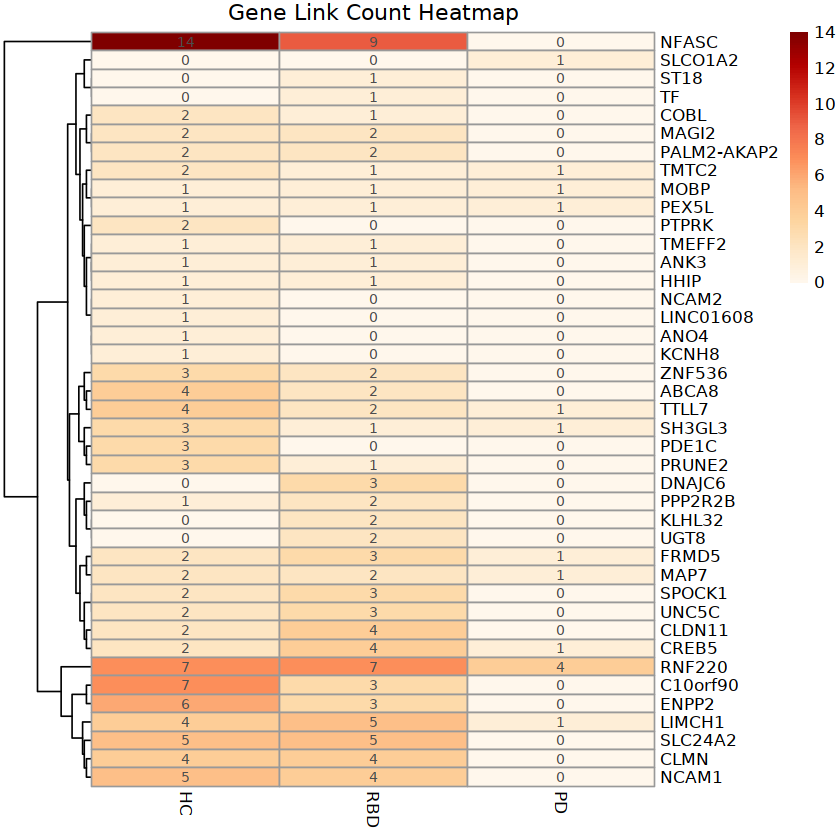

In [ ]:
# Define folder paths
hc_folder <- "../../Signac_plots/HC/Marker_Genes_Cluster3/gene_link_counts.csv"
rbd_folder <- "../../Signac_plots/RBD/Marker_Genes_Cluster3/gene_link_counts.csv"
pd_folder <- "../../Signac_plots/PD/Marker_Genes_Cluster3/gene_link_counts.csv"
output_folder <- "../../Signac_plots/Combined/Marker_Genes_Cluster3_squeeze"

# Combine plots
# combine_gene_plots(hc_folder, rbd_folder, pd_folder, output_folder)
plot_link_count_heatmap(hc_folder, rbd_folder, pd_folder, output_folder)

In [3]:
library(ggplot2)
library(tidyr)
library(pheatmap)
library(dplyr)
library(gridExtra)

plot_link_count_heatmap <- function(hc_file, rbd_file, pd_file, output_folder) {
  # Read CSV files
  hc_data <- read.csv(hc_file)
  rbd_data <- read.csv(rbd_file)
  pd_data <- read.csv(pd_file)
  
  # Add disease status column
  hc_data$disease_status <- "HC"
  rbd_data$disease_status <- "RBD"
  pd_data$disease_status <- "PD"
  
  # Combine data
  combined_data <- bind_rows(hc_data, rbd_data, pd_data)
  
  # Reshape data into wide format
  link_count_matrix <- combined_data %>%
    select(gene, disease_status, link_count) %>%
    pivot_wider(names_from = disease_status, values_from = link_count, values_fill = list(link_count = 0))  # Fill missing values with 0
  
  link_count_matrix <- as.data.frame(link_count_matrix)

  # Use the 'gene' column as row names, then remove it once
  rownames(link_count_matrix) <- link_count_matrix$gene
  link_count_matrix$gene <- NULL

  # Now convert to matrix without stripping any additional columns
  link_count_matrix <- as.matrix(link_count_matrix)
  
  # Define custom color palette
  custom_colors <- c('#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#b30000','#7f0000')

  # Ensure output folder exists
  if (!dir.exists(output_folder)) {
    dir.create(output_folder, recursive = TRUE)
  }
  
  # Generate filename
  filename <- file.path(output_folder, "gene_link_count_heatmap.pdf")
  
  # Adjust PDF size dynamically based on the number of genes
  x <- pheatmap(link_count_matrix, 
           cluster_rows = TRUE, 
           cluster_cols = FALSE, 
           color = colorRampPalette(custom_colors)(100), 
           main = "Gene Link Count Heatmap",
           display_numbers = link_count_matrix,  # Show actual integer values
           number_format = "%.0f",  # Display numbers as integers
           labels_row = rownames(link_count_matrix),  # Ensure row names are displayed
           fontsize_row = 10)  # Increase row font size for readability

  # Save the heatmap to PDF
  pdf(filename, width=3, height=15)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
  message("Heatmap saved to: ", filename)
}

Heatmap saved to: ~/Documents/HCPDRBD/Signac_plots/Combined/DAM_AD_squeeze/gene_link_count_heatmap.pdf



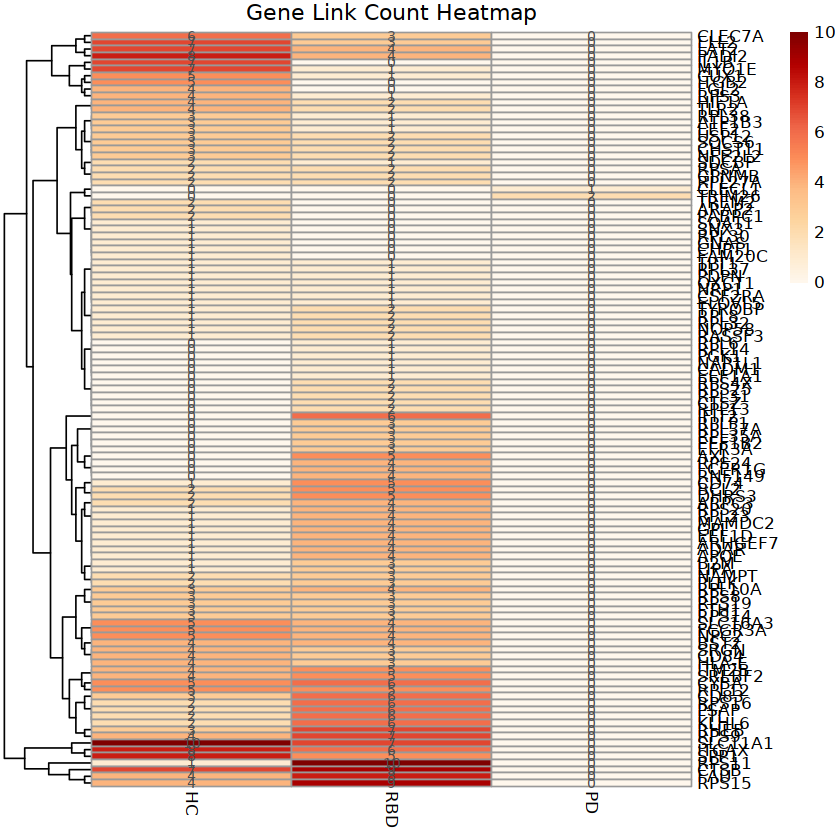

In [ ]:
# Define folder paths
hc_folder <- "../../Signac_plots/HC/DAM_AD/gene_link_counts.csv"
rbd_folder <- "../../Signac_plots/RBD/DAM_AD/gene_link_counts.csv"
pd_folder <- "../../Signac_plots/PD/DAM_AD/gene_link_counts.csv"
output_folder <- "../../Signac_plots/Combined/DAM_AD_squeeze"

# Combine plots
# combine_gene_plots(hc_folder, rbd_folder, pd_folder, output_folder)
plot_link_count_heatmap(hc_folder, rbd_folder, pd_folder, output_folder)

Heatmap saved to: ~/Documents/HCPDRBD/Signac_plots/Combined/DAM_AD/gene_link_count_heatmap.pdf



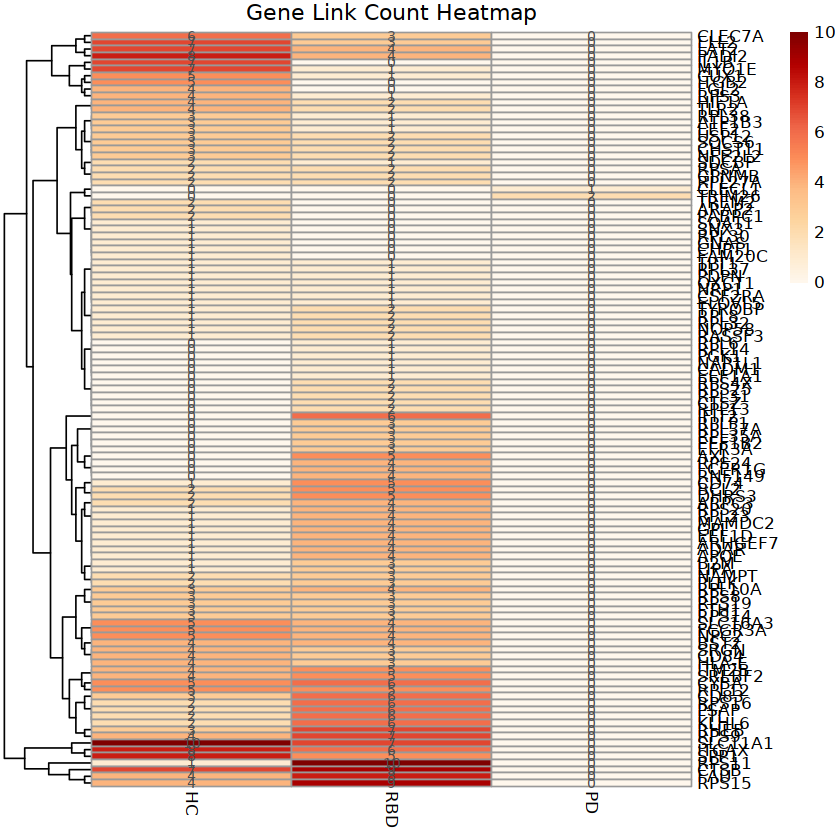

In [ ]:
# Define folder paths
hc_folder <- "../../Signac_plots/HC/DAM_AD/gene_link_counts.csv"
rbd_folder <- "../../Signac_plots/RBD/DAM_AD/gene_link_counts.csv"
pd_folder <- "../../Signac_plots/PD/DAM_AD/gene_link_counts.csv"
output_folder <- "../../Signac_plots/Combined/DAM_AD"

# Combine plots
# combine_gene_plots(hc_folder, rbd_folder, pd_folder, output_folder)
plot_link_count_heatmap(hc_folder, rbd_folder, pd_folder, output_folder)

# DEG Exn RORB

Heatmap saved to: ~/Documents/HCPDRBD/Signac_plots/Combined/DEGs_RORB_exn_squeeze/gene_link_count_heatmap.pdf



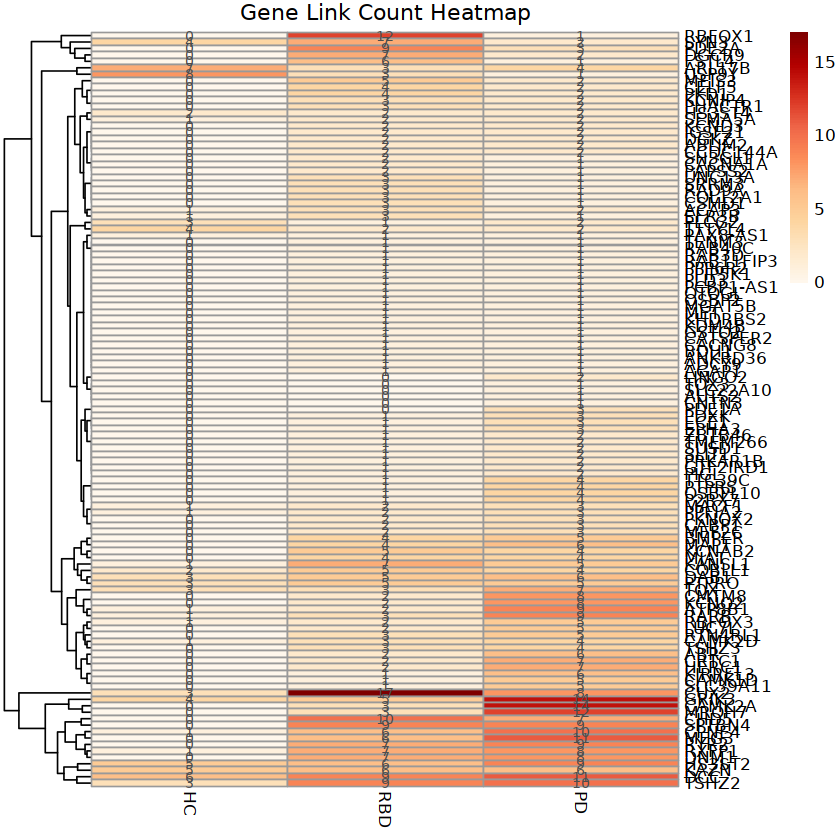

In [ ]:
# Define folder paths
hc_folder <- "../../Signac_plots/HC/DEGs_RBD_PD_vs_HC_RORB_exn/gene_link_counts.csv"
rbd_folder <- "../../Signac_plots/RBD/DEGs_RBD_vs_HC_RORB_exn/gene_link_counts.csv"
pd_folder <- "../../Signac_plots/PD/DEGs_PD_vs_HC_RORB_exn/gene_link_counts.csv"
output_folder <- "../../Signac_plots/Combined/DEGs_RORB_exn_squeeze"

# Combine plots
# combine_gene_plots(hc_folder, rbd_folder, pd_folder, output_folder)
plot_link_count_heatmap(hc_folder,rbd_folder, pd_folder, output_folder)

# Marker Gene Exn RORB

Heatmap saved to: ~/Documents/HCPDRBD/Signac_plots/Combined/Marker_Genes_RORB_exn_squeeze/gene_link_count_heatmap.pdf



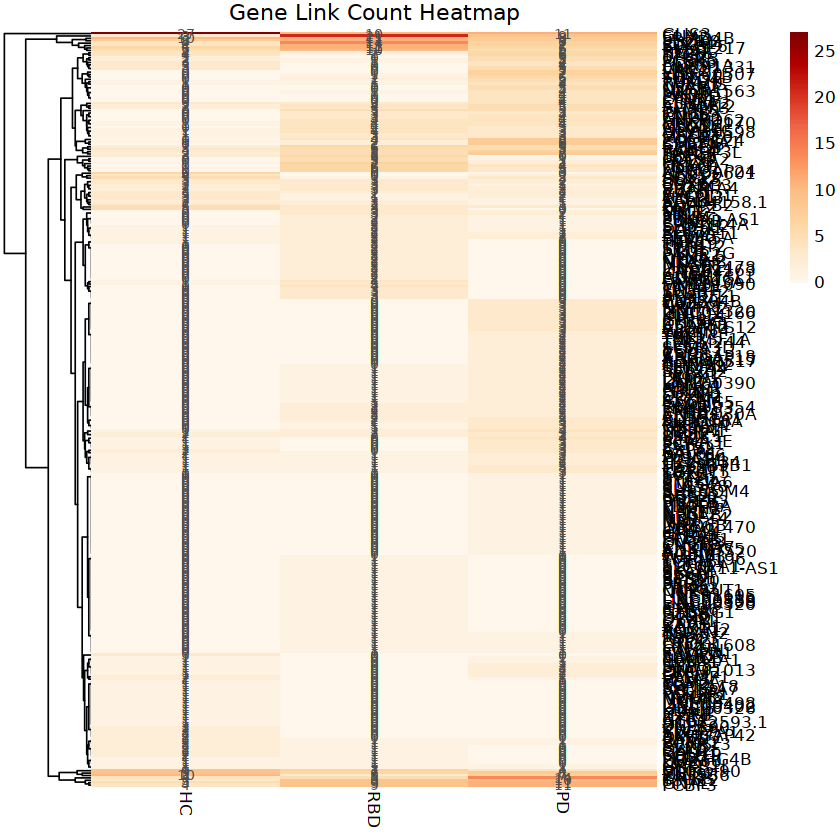

In [ ]:
# Define folder paths
hc_folder <- "../../Signac_plots/HC/Marker_Genes_RORB_exn/gene_link_counts.csv"
rbd_folder <- "../../Signac_plots/RBD/Marker_Genes_RORB_exn/gene_link_counts.csv"
pd_folder <- "../../Signac_plots/PD/Marker_Genes_RORB_exn/gene_link_counts.csv"
output_folder <- "../../Signac_plots/Combined/Marker_Genes_RORB_exn_squeeze"

# Combine plots
# combine_gene_plots(hc_folder, rbd_folder, pd_folder, output_folder)
plot_link_count_heatmap(hc_folder, rbd_folder, pd_folder, output_folder)

# DEG Inh Subset

Heatmap saved to: ~/Documents/HCPDRBD/Signac_plots/Combined/DEGs_Inh_squeeze/gene_link_count_heatmap.pdf



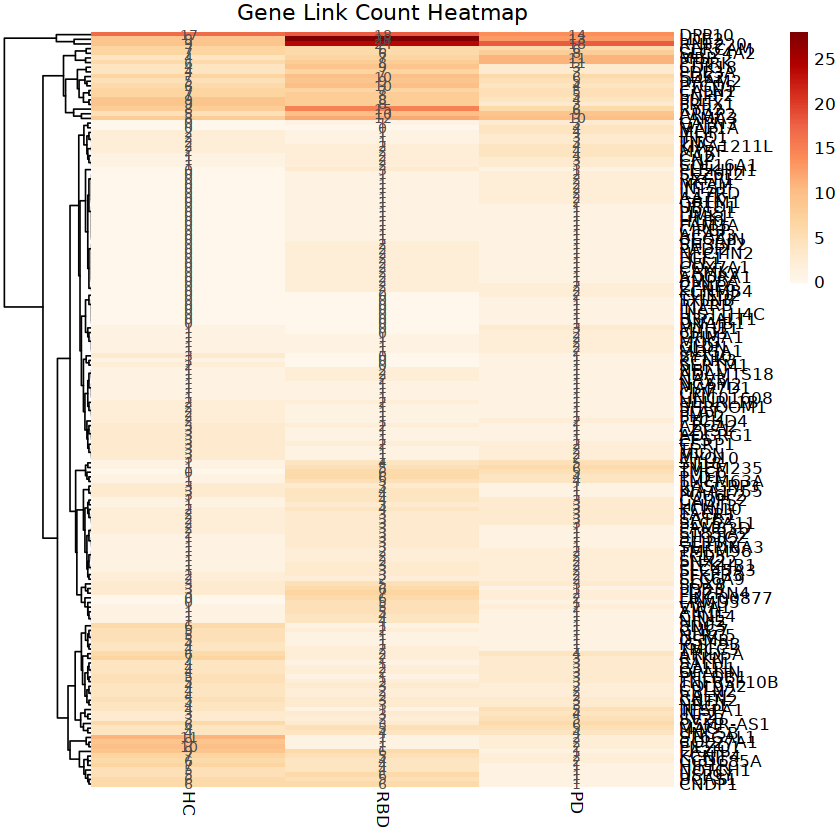

In [ ]:
# Define folder paths
hc_folder <- "../../Signac_plots/HC/DEGs_RBD_PD_vs_HC_Inh/gene_link_counts.csv"
rbd_folder <- "../../Signac_plots/RBD/DEGs_RBD_vs_HC_Inh/gene_link_counts.csv"
pd_folder <- "../../Signac_plots/PD/DEGs_PD_vs_HC_Inh/gene_link_counts.csv"
output_folder <- "../../Signac_plots/Combined/DEGs_Inh_squeeze"

# Combine plots
# combine_gene_plots(hc_folder, rbd_folder, pd_folder, output_folder)
plot_link_count_heatmap(hc_folder,rbd_folder, pd_folder, output_folder)